In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [6]:
def showImage(img, title=''):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if(title != ''):
        plt.title(title)

    plt.imshow(img)
    plt.show()

def saveimage(img, img_name, path='output'):
    path = path + '/' + str(img_name) + '.jpg'
    cv2.imwrite(path, img)
    print('save image success !!')

class Pre_Processing:

    def __init__(self, img, debug=False):
        self.debug = debug 

        self.image =  img
        self.gray_image = self.convertColorSpace(self.image)
        self.remove_shadow_image = self.removeShadow(self.gray_image)
        self.binary_image = self.convert2binaryImage(self.remove_shadow_image)

    def convertColorSpace(self, img):
        image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if(self.debug):
            showImage(image)

        return image

    def removeShadow(self, gray_img):
        dilated_img = cv2.dilate(gray_img, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 99)
        diff_img = 255 - cv2.absdiff(gray_img, bg_img)
        norm_img = diff_img.copy()
        cv2.normalize(diff_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)


        if(self.debug):
            showImage(dilated_img, 'dilated image')
            showImage(bg_img, 'get background')
            showImage(diff_img, 'remove shadow')
        
        return diff_img

    def convert2binaryImage(self, gray_img):
        
        bilateral = cv2.bilateralFilter(gray_img, 11, 40, 40)
        blur = cv2.GaussianBlur(bilateral,(5,5),0)
        thresh_img = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 35, 10)

        if(self.debug):
            showImage(bilateral, 'bilateral image')
            showImage(blur, 'blur')
            showImage(thresh_img, 'binary image')
        return thresh_img

In [7]:
# resize image
def resizeImage(img):
    expect_width, expect_height = 28, 28

    height = int(img.shape[0])
    width = int(img.shape[1])

    print('img size (width, height): ({},{})'.format(width,height))

    min_ = min(width,height)

    if(width == min_):
        ratio_w = 1
        ratio_h = width*1/height
        new_dimension = ( int(expect_width*ratio_h / ratio_w), expect_width)
    else:
        ratio_w = width*1/height
        ratio_h = 1
        new_dimension = ( expect_width, int(expect_width*ratio_h / ratio_w))
        

    print('ratio : {},{}'.format(ratio_w, ratio_h))


    img_resize = cv2.resize(img, new_dimension, interpolation=cv2.INTER_AREA)

    w, h = 28, 28
    top_pad = int(np.floor((h - img_resize.shape[0]) / 2).astype(np.uint16))
    bottom_pad = int(np.ceil((h - img_resize.shape[0]) / 2).astype(np.uint16))

    right_pad = int(np.ceil((w - img_resize.shape[1]) / 2).astype(np.uint16))
    left_pad = int(np.floor((w - img_resize.shape[1]) / 2).astype(np.uint16))

    print("pad : (top,bottom) , (left,right) = ({},{}), ({},{})".format(top_pad,bottom_pad,left_pad,right_pad))

    img_resize = np.pad(img_resize, [ (top_pad,bottom_pad) , (left_pad,right_pad) ], "constant", constant_values=0)

    return img_resize

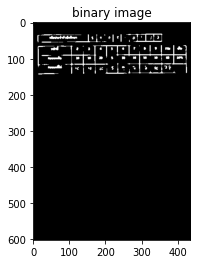

save image success !!


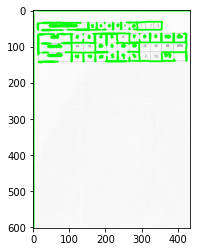

save image success !!


IndexError: list index out of range

In [11]:
if __name__ == "__main__":
    img = cv2.imread('image_test/Picture1.png')
    bi_img = Pre_Processing(img).binary_image

    showImage(bi_img, 'binary image')
    saveimage(bi_img,'binaryyy')

    # External contours
    contours, _ = cv2.findContours(bi_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (0,255,0), 3)
    showImage(img)
    saveimage(img,'tt')

    # segmentationBox
    boxlist = []
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

        if(len(approx) == 4):
            x, y, w, h = cv2.boundingRect(approx)

            if(w > 150):
                boxlist.append(bi_img[y:y+h, x:x+w])

    id_box = boxlist[0]
    score_box = boxlist[1]
    for box in boxlist:
        if(box.shape[1] > id_box.shape[1]):
            score_box = id_box
            id_box = box
    
    showImage(id_box, 'id box')
    showImage(score_box, 'score box')

    # segment id box
    contours, _ = cv2.findContours(id_box, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(img, contours, -1, (0,255,0), 3)
    
    id_list = []
    i = 0
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

        if(len(approx) == 4):
            x, y, w, h = cv2.boundingRect(approx)

            if(w > 150 and w < 200):
                i += 1
                box = id_box[y+20:y+h-20, x+20:x+w-20]
            
                id_list.append(box)

                showImage(box,'width : {}, height : {}'.format(w,h))
    
    # segment num
    for id_b in id_list:
        
        contours, _ = cv2.findContours(id_b, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

            print("approx : {}, {}".format(len(approx), approx))

            x, y, w, h = cv2.boundingRect(approx)

            b = id_b[y:y+h, x:x+w]
            img_resized = resizeImage(b)

            showImage(img_resized, 'resized image (w {}:h {})'.format(img_resized.shape[0],img_resized.shape[1]))
            showImage(b, 'id_box')

        print('--------')

        #showImage(id_b, 'id box')



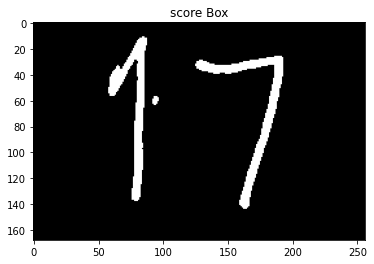

score (256,168)


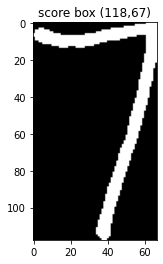

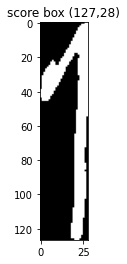

In [17]:
# segment score box

score_box = score_box[+30:-30,+30:-30]
showImage(score_box, 'score Box')
contours, _ = cv2.findContours(score_box, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("score ({},{})".format(score_box.shape[1], score_box.shape[0]))
for cnt in contours:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

    #print("approx : {}, {}".format(len(approx), approx))

    x, y, w, h = cv2.boundingRect(approx)

    b = score_box[y:y+h, x:x+w]

    if(h > 20 and h < score_box.shape[0] and w < score_box.shape[1]):
        showImage(b,'score box ({},{})'.format(b.shape[0], b.shape[1]))
    